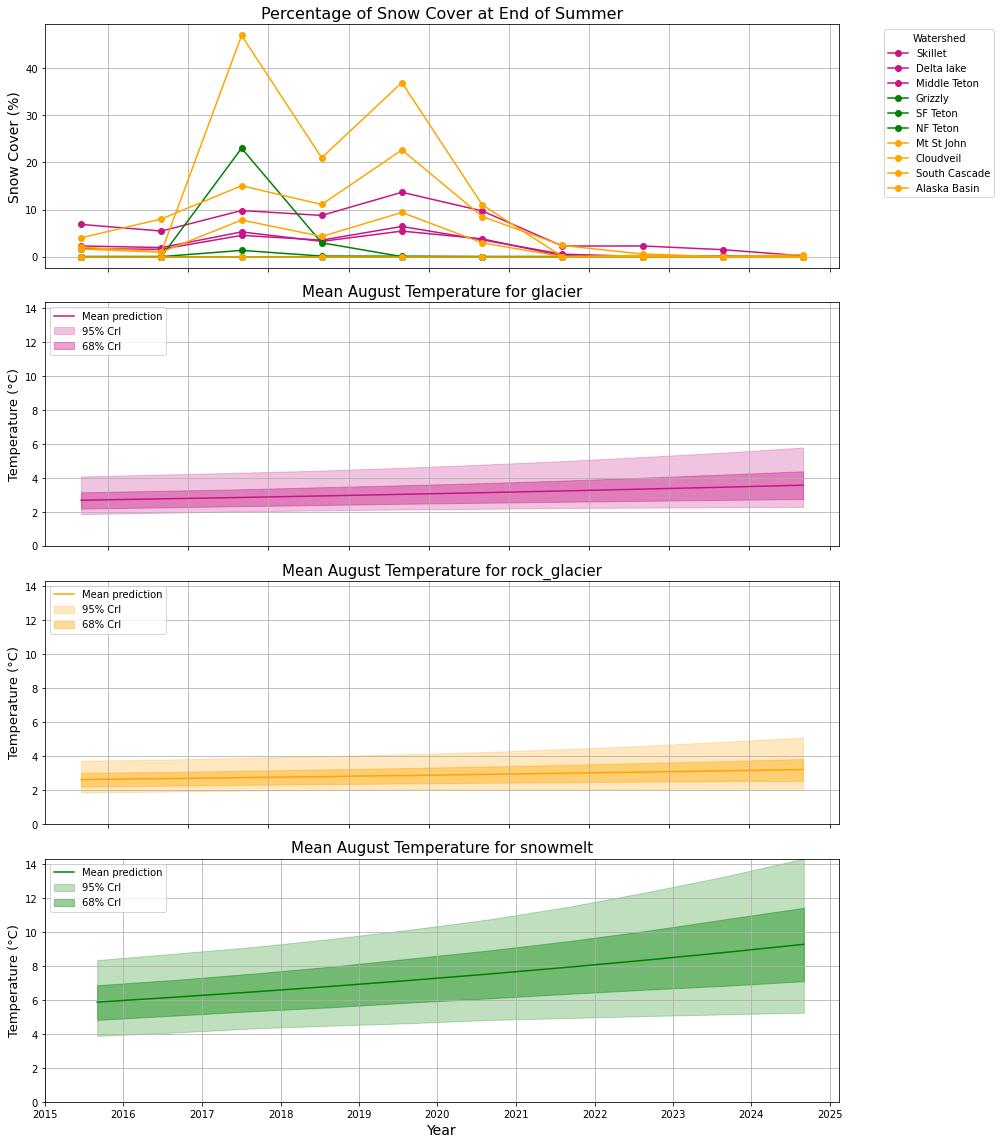

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load Snow Cover Data
snow_df = pd.read_csv("D:/Desktop/Teton/Teton DEMS for arcgis/dem_for_figure/Teton_watershed_Sentinel_2_2015_2024.csv", index_col=0)
snow_df.index = snow_df.index.str.strip().str.replace(":", "", regex=False)
snow_df = snow_df.applymap(lambda x: float(x.strip('%')) if isinstance(x, str) and '%' in x else float(x))
snow_df.columns = snow_df.columns.astype(int)

custom_colors = {
    'Skillet': 'mediumvioletred',
    'Delta lake': 'mediumvioletred',
    'Middle Teton': 'mediumvioletred',
    'Cloudveil': 'orange',
    'South Cascade': 'orange',
    'Mt St John': 'orange',
    'Grizzly': 'green',
    'SF Teton': 'green',
    'NF Teton': 'green',
    'Alaska Basin': 'orange'
}

# Load Temperature Prediction Data
temp_df = pd.read_csv("source_epred_time_data.csv")
temp_df['date'] = pd.to_datetime(temp_df['date'])
temp_df.columns = temp_df.columns.str.strip()
temp_df['year'] = temp_df['date'].dt.year

# Summarize posterior predictions
summary_df = (
    temp_df.groupby(['source', 'year'])
    .agg({
        '.epred': [
            ('epred', 'mean'),
            ('lower_0_68', lambda x: x.quantile(0.16)),
            ('upper_0_68', lambda x: x.quantile(0.84)),
            ('lower_0_95', lambda x: x.quantile(0.025)),
            ('upper_0_95', lambda x: x.quantile(0.975))
        ]
    })
)
summary_df.columns = [name for _, name in summary_df.columns]
summary_df = summary_df.reset_index()
summary_df['plot_date'] = pd.to_datetime(summary_df['year'].astype(str) + "-09-01")

source_color_map = {
    "glacier": "mediumvioletred",
    "rock_glacier": "orange",
    "snowmelt": "green"
}

# Remove any NaN index rows
snow_df = snow_df[~snow_df.index.isna()]


# Plot settings
sources = summary_df['source'].unique()
n_temp_sources = len(sources)
min_year = min(snow_df.columns.min(), summary_df['year'].min())
all_years = list(range(min_year, 2026))
all_dates = pd.to_datetime([f"{y}-09-01" for y in all_years])
year_ticks = pd.date_range(start=f"{min_year}-01-01", end="2025-01-01", freq="YS")

# Fill missing years in snow_df
for year in all_years:
    if year not in snow_df.columns:
        snow_df[year] = float('nan')
snow_df = snow_df[sorted(snow_df.columns)]
snow_dates = pd.to_datetime([f"{y}-09-01" for y in snow_df.columns])


# Create figure and axes
fig, axes = plt.subplots(nrows=1 + n_temp_sources, ncols=1, figsize=(14, 4 + 4 * n_temp_sources), sharex=True)

# Plot snow cover
ax1 = axes[0]
for watershed in snow_df.index:
    color = custom_colors.get(watershed, "#333333")
    ax1.plot(snow_dates, snow_df.loc[watershed], marker='o', label=watershed, color=color)

ax1.set_title("Percentage of Snow Cover at End of Summer", fontsize=16)
ax1.set_ylabel("Snow Cover (%)", fontsize=14)
ax1.grid(True)
ax1.legend(title="Watershed", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.set_xticks(year_ticks)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Compute shared y-axis limits for temperature
temp_min = 0
temp_max = summary_df[['upper_0_95']].max().values[0]

# Plot each temperature source
for i, source in enumerate(sources):
    ax = axes[i + 1]
    src = summary_df[summary_df['source'] == source]
    color = source_color_map.get(source, "#333333")

    ax.fill_between(src['plot_date'], src['lower_0_95'], src['upper_0_95'], color=color, alpha=0.25, label="95% CrI")
    ax.fill_between(src['plot_date'], src['lower_0_68'], src['upper_0_68'], color=color, alpha=0.4, label="68% CrI")
    ax.plot(src['plot_date'], src['epred'], color=color, label="Mean prediction")

    ax.set_title(f"Mean August Temperature for {source}", fontsize=15)
    ax.set_ylabel("Temperature (°C)", fontsize=13)
    ax.set_ylim(temp_min, temp_max)
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_xticks(year_ticks)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Label x-axis only on last plot
axes[-1].set_xlabel("Year", fontsize=14)

plt.tight_layout()
plt.savefig("teton_snow_temp_plot.jpg", dpi=300, bbox_inches='tight', format='jpeg')
plt.show()

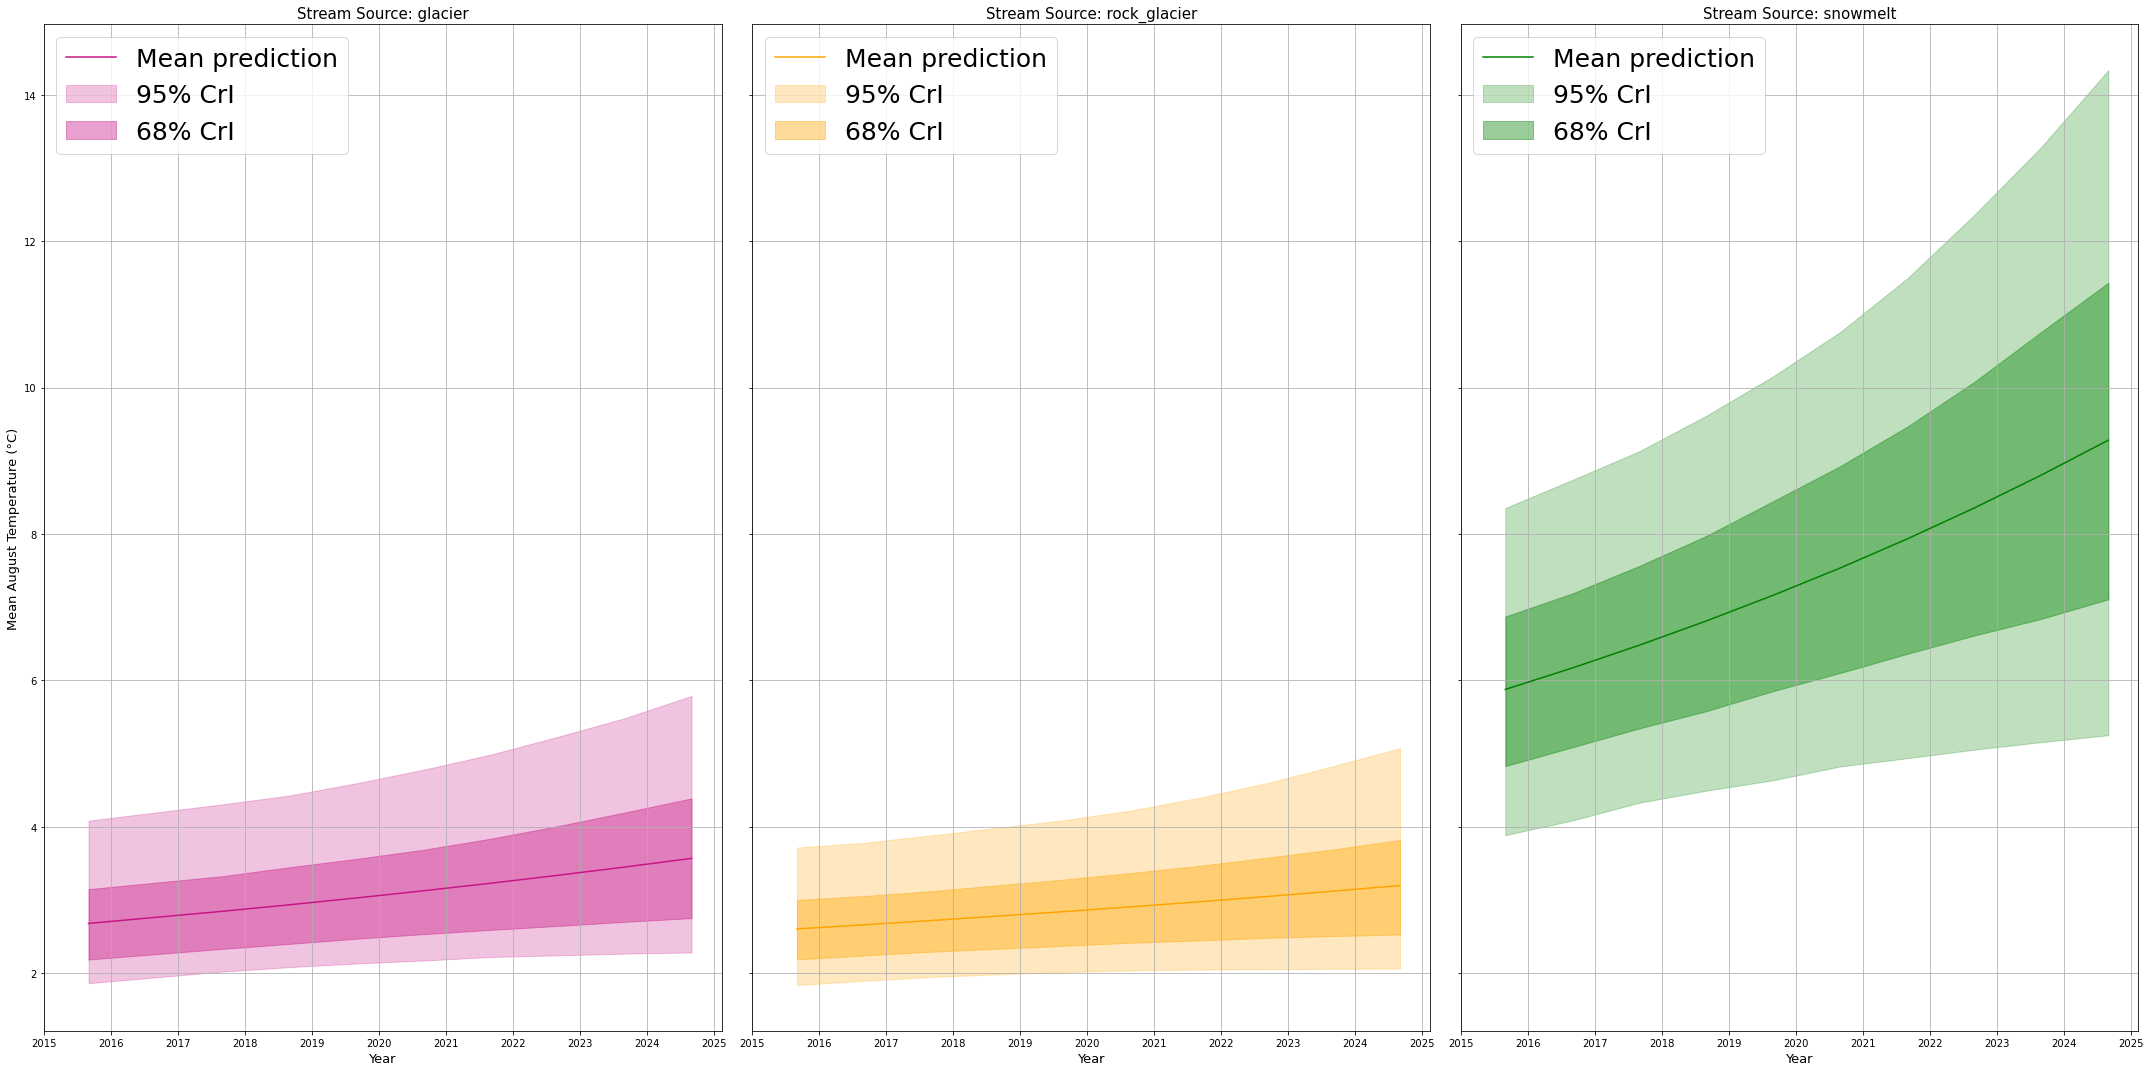

In [2]:

# Load Temperature Prediction Data
temp_df = pd.read_csv("source_epred_time_data.csv")
temp_df['date'] = pd.to_datetime(temp_df['date'])
temp_df.columns = temp_df.columns.str.strip()
temp_df['year'] = temp_df['date'].dt.year

# Summarize posterior predictions
summary_df = (
    temp_df.groupby(['source', 'year'])
    .agg({
        '.epred': [
            ('epred', 'mean'),
            ('lower_0_68', lambda x: x.quantile(0.16)),
            ('upper_0_68', lambda x: x.quantile(0.84)),
            ('lower_0_95', lambda x: x.quantile(0.025)),
            ('upper_0_95', lambda x: x.quantile(0.975))
        ]
    })
)
summary_df.columns = [name for _, name in summary_df.columns]
summary_df = summary_df.reset_index()
summary_df['plot_date'] = pd.to_datetime(summary_df['year'].astype(str) + "-09-01")

# Define colors for each stream type
source_color_map = {
    "glacier": "mediumvioletred",
    "rock_glacier": "orange",
    "snowmelt": "green"
}

# Determine layout
sources = summary_df['source'].unique()
n_sources = len(sources)
year_ticks = pd.date_range(start=str(summary_df['year'].min()), end="2025", freq="YS")

# Determine global y-axis range
temp_min = 0
temp_max = summary_df[['upper_0_95']].max().values[0]

# Create horizontally stacked plots
fig, axes = plt.subplots(nrows=1, ncols=n_sources, figsize=(10 * n_sources, 15), sharey=True)

# Plot each source
for i, source in enumerate(sources):
    ax = axes[i]
    src = summary_df[summary_df['source'] == source]
    color = source_color_map.get(source, "#333333")

    ax.fill_between(src['plot_date'], src['lower_0_95'], src['upper_0_95'], color=color, alpha=0.25, label="95% CrI")
    ax.fill_between(src['plot_date'], src['lower_0_68'], src['upper_0_68'], color=color, alpha=0.4, label="68% CrI")
    ax.plot(src['plot_date'], src['epred'], color=color, label="Mean prediction")

    ax.set_title(f"Stream Source: {source}", fontsize=15)
    ax.set_xlabel("Year", fontsize=13)
    ax.set_xticks(year_ticks)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True)
    ax.legend(loc='upper left', fontsize=25)
    if i == 0:
        ax.set_ylabel("Mean August Temperature (°C)", fontsize=13)

plt.tight_layout()
plt.savefig("stream_temperature_horizontal.jpg", dpi=300, bbox_inches='tight', format='jpeg')
plt.show()